Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [15]:
NAME = ""
COLLABORATORS = ""

---

# Vaja 10: Lokalizacija v prostoru na podlagi slike
## Navodila
Če na robota namestimo *tipalo okolice* in ga vozimo po prostoru ter zajemamo meritve *okolice*, lahko na podlagi teh meritev izvedemo hkratno lokalizacijo robota v prostoru in izgradnjo mape tega prostora. Numerične tehnike, ki to omogočajo, označujemo pod skupnim imenom **SLAM** (ang. Simultaneous Localization And Mapping). Prve tovrstne tehnike so kot meritev okolice uporabljale senzor razdalje (ultrazvočni, laserski (LIDAR), ipd.), v tej vaji pa se bomo posvetili tehnikam, ki temeljijo na vizualni informaciji -- sliki zajeti s kamero, ki je na robotu. Te tehnike označujemo tudi kot **Visual SLAM** in zajemajo tudi vizualno odometrijo (VO ang. Visual Odometry) in 3D rekonstrukcijo na podlagi gibanja (SfM ang. Structure from Motion).

| Visual SLAM: primer rekonstrukcije 3D prostora in trajektorije gibanja kamere. |
|:---:|
![Visual SLAM](images/RV_10_SLO_VisualSLAM.jpg)


Pri tej vaji boste na podlagi zaporedja slik zajetih z eno *premično* kamero rekonstruirali 3D mapo prostora in določili trajektorijo gibanja kamere v prostoru. S to informacijo lahko kasneje načrtujemo povratno-zančno vodenje robota s kamero tako, da se robot zaveda prostora okoli sebe, npr. aktivno izogiba oviram v prostoru.

Osnovni gradniki postopka *Visual SLAM* so:
1. rekonstrukcija 3D scene na podlagi triangulacije, podobno kot pri rekonstrukciji s stereo parom kamer; 
2. ocena esencialne matrike preslikave med dvema slikama; in 
3. analiza esencialne matrike za določanje premika oz. relativne poze kamere ($R,T$). 

Če želimo pridobiti metrično rekonstrukcijo 3D prostora je potrebna tudi kalibracija kamere (intrinzični parametri $K$) in prisotnost kalibracijskih objektov vsaj v enem paru slik, v nasprotnem primeru bo rekonstrukcija 3D prostora skalirana s poljubno skalo (brez kalibracijskega objekta) ali deformirana s poljubno projektivno preslikavo (brez kalibracije kamere).

**Triangulacija** 3D položaja točke $P^i=[X^i, Y^i, Z^i, 1]^{\mathrm{T}}$ v prostoru je možna na podlagi dveh projekcij te točke $\mathbf{p}_1^i=[u_1^i, v_1^i, 1]^{\mathrm{T}}$ in $\mathbf{p}_2^i=[u_2^i, v_2^i, 1]^{\mathrm{T}}$ na dveh slikah iz dveh pogledov s pripadajočimi projekcijskimi matrikami $M_1$ in $M_2$ z dimenzijami $3\times 4$. Za rekonstrukcijo $P^i$ zgradimo linearni sistem enačb:

##### Triangulacija
$$
\begin{bmatrix}
[{\mathbf{p}_1^i}]_{\times} M_1 \\
[{\mathbf{p}_2^i}]_{\times} M_2
\end{bmatrix}
\cdot P^i = 0 \rightarrow A \cdot P^i = 0
$$

pri čemer ima matrika $A$ dimenzije $6\times 4$. Notacija $[\mathbf{x}]_{\times}$ predstavlja pretvorbo vektorja $\mathbf{x}=[x_1 x_2 x_3]^{\mathrm{T}}$ v poševno simetrično matriko:

$$
[\mathbf{x}]_{\times} = 
	\left[\begin{array}{ccc} 
	0 & -x_3 & x_2\\   
	x_3 & 0 & -x_1\\   
	-x_2 & x_1 & 0\\   
	\end{array}\right]\,.
$$

Iščemo netrivialno rešitev sistema, ki minimizira $\|AP^i\|^2$ ob pogoju $\|P^i\|=1$. Rešitev dobimo tako, da poiščemo najmanjšo lastno vrednost $A^{\mathrm{T}}A$, pripadajoči lastni vektor pa predstavlja rešitev za $P^i$. To lahko storimo z uporabo SVD razcepa matrike $A=U\Sigma V^{\mathrm{T}}$, kjer sta matriki $U,\,V$ unitarni in $\Sigma$ diagonalna matrika s singularnimi vrednostmi, tako, da poiščemo najmanjšo singularno vrednost in pripadajoči stolpec v matriki $V$.

**Esencialna matrika** $E$ opisuje epipolarno geometrijo kalibriranega stereo sistema kamer tako, da za *normalizirane koordinate* pripadajočih projekcij $\bar{\mathbf{p}}_1 \leftrightarrow \bar{\mathbf{p}}_2$, kjer normaliziramo kot $\bar{\mathbf{p}}_j=K_j^{-1} \mathbf{p}_j\,j=1,2$, velja enačba:

##### Esencialna matrika
$$
\bar{\mathbf{p}}_2^{\mathrm{T}} E \bar{\mathbf{p}}_1 = 0\,,
$$

matrika s strukturo $E=[T]_{\times} R$ pa kodira relativen položaj med kamerama. Če normalizirane koordinate nadomestimo z originalnimi dobimo zvezo:

##### Fundamentalna matrika
$$
\begin{array}{rcccl}
	(K_2^{-1} \mathbf{p}_2)^{\mathrm{T}} E K_1^{-1} \mathbf{p}_1 = 0 &
	\rightarrow &	
	\mathbf{p}_2^{\mathrm{T}} (K_2^{-T}  E K_1^{-1}) \mathbf{p}_1 = 0 &
	\rightarrow &
	\mathbf{p}_2^{\mathrm{T}} F \mathbf{p}_1 = 0\,,
	\end{array}	
$$

kjer je $F$ **fundamentalna matrika**. Enačba velja tudi v primeru, ko sta kameri nekalibrirani, saj vsebuje nenormalizirane koordinate $\mathbf{p}_1$ in $\mathbf{p}_2$. Enačbi predstavljata lastnost epipolarne geometrije, da vektorja $\bar{\mathbf{p}}_1$ in $\bar{\mathbf{p}}_2$ (in tudi $\mathbf{p}_1$ in $\mathbf{p}_2$) ležita v epipolarni ravnini. Matriki $E$ in $F$ imata dimenzije $3\times 3$ in rang 2, zato bo determinanta $\det{E}=0$ in $\det{F}=0$.

| Rekonstrukcija 3D položaja točke $P$ na podlagi dveh projekcij $p_1$ in $p_2$. |
|---|
| ![Triangulacija](images/RV_10_SLO_Triangulacija.png) |

### Ocenjevanje esencialne matrike $E$
Esencialno in fundamentalno matriko določimo na enak način z uporabo algoritma **osmih točk**. Za dano množico pripadajočih parov točk $\{\mathbf{p}_1^i \leftrightarrow \mathbf{p}_2^i\}_{i=1,\ldots,N}$ lahko enačbo zapišemo kot:

##### Algoritem osmih točk
$$
(\mathbf{p}_1^{i} \otimes \mathbf{p}_2^i)^{\mathrm{T}}\, \mathrm{vec}(F) = 0,\,\mathrm{kjer\; je}\;Q =
	\left[\begin{array}{c}
	(\mathbf{p}_1^{1} \otimes \mathbf{p}_2^N)^{\mathrm{T}}\\
	\vdots\\
	(\mathbf{p}_1^{N} \otimes \mathbf{p}_2^N)^{\mathrm{T}}\\
	\end{array}\right]
	\quad\rightarrow\quad Q\cdot \mathrm{vec}(F)=0\,.
$$

Notacija $\mathrm{vec}(F)$ pomeni zapis elementrov matrike $F$ v obliki vektorja. Simbol $\otimes$ pa predstavlja Kronekerjev produkt, npr.:

$$
\mathbf{p}_1^{i} \otimes \mathbf{p}_2^i = 
	\left[\begin{array}{ccc}
		u_{1}^i \cdot \mathbf{p}_2^{i\top}&
		v_{1}^i \cdot \mathbf{p}_2^{i\top}&
		1 \cdot \mathbf{p}_2^{i\top}
	\end{array}\right]^{\mathrm{T}}\,,
$$

ki iz dveh trovrstičnih vektorjev ($3 \times 1$) ustvari devetvrstični vektor ($9 \times 1$). Za rešitev enačbe potrebujemo $N\geq 8$ pripadajočih parov točk. Rešitev dobimo z uporabo SVD razcepa, podobno kot pri triangulaciji, pri čemer pa moramo zagotoviti, da bo $\det{F}=0$. To enostavno naredimo tako, da najmanjšo singularno vrednost v $\Sigma = \mathrm{diag}(\{\sigma_j\}_{j=1,2,3})$ postavimo na 0, npr:

##### SVD resitev
$$
	F=U 
	\left[\begin{array}{ccc}
	\sigma_1 & 0 & 0\\
	0 & \sigma_2 & 0\\
	0 & 0 & \sigma_3		
	\end{array}\right]
	V^{\mathrm{T}}
	\quad\rightarrow\quad
	F=U 
	\left[\begin{array}{ccc}
	\sigma_1 & 0 & 0\\
	0 & \sigma_2 & 0\\
	0 & 0 & 0		
	\end{array}\right]
	V^{\mathrm{T}}\,.
$$

Numerično stabilnost zgoraj opisanega algoritma lahko izboljšamo s središčenjem in skaliranjem koordinat $\{\mathbf{p}_1^i\}$ in $\{\mathbf{p}_2^i\}$ tako, da bo njihova srednja vrednost enaka 0, standardna deviacija pa $\sqrt{2}$. Za vsako točko $i$ in množico točk $j=1,2$ naredimo preslikavo:

##### Skaliranje koordinat
$$
\tilde{\mathbf{p}}_j^i = \frac{\sqrt{2}}{\rho_j}\left(\mathbf{p}_j^i - \mu_j\right)\,,\;\mathrm{oziroma}\quad
	\tilde{\mathbf{p}}_j^i = 
	\left[\begin{array}{ccc}
	s_j & 0   & -s_j \mu_j^x \\
	0   & s_j & -s_j \mu_j^y \\
	0   & 0   & 1\\
	\end{array}\right] \mathbf{p}_j^i
	\quad\rightarrow\quad
	\tilde{\mathbf{p}}_j^i = T_j \mathbf{p}_j^i\,.
$$

kjer sta $\mu_j=\frac{1}{N}\sum_i \mathbf{p}_j^i$ in $\rho_j=\frac{1}{N}\sum_i \|\mathbf{p}_j^i - \mu_j\|^2$. V naslednjem koraku s središčenimi in skaliranimi korespondenčnimi točkami $\{\tilde{\mathbf{p}}_1^i\leftrightarrow\tilde{\mathbf{p}}_2^i\}$ ocenimo fundamentalno matriko $\tilde{F}$ po enačbah [algoritma osmih točk](#Algoritem-osmih-točk) in [SVD resitev](#SVD-resitev). Nato kompenziramo središčenje in skaliranje, da dobimo fundamentalno matriko $F = T_2^{\mathrm{T}}\tilde{F} T_1$. Če poznamo tudi intrinzične parametre kamer ($K_1$ in $K_2$) lahko glede na [fundamentalno matriko](#Fundamentalna-matrika) določimo še esencialno matriko kot $E=K_2^{\mathrm{T}} F K_1$.

### Določanje poze $(R,T)$ iz esencialne matrike $E$
Naj bo svetovni koordinatni sistem v kameri $j=1$. Potem lahko pripadajočo projekcijsko matriko določimo kot $M_1 = K_1 [I | 0]$. Relativno pozo $(R,T)$ kamere $j=2$ bomo določili iz esencialne matrike $E=[T]_{\times} R$, pri čemer obstajajo štiri možne rešitve:

##### Rešitve poze
$$
[R_1|T_1] = [UWV^{\mathrm{T}} | u_3]
$$
$$
[R_2|T_2] = [UW^{\mathrm{T}}V^{\mathrm{T}} | u_3]
$$
$$
[R_3|T_3] = [UWV^{\mathrm{T}} | -u_3]
$$
$$
[R_4|T_4] = [UW^{\mathrm{T}}V^{\mathrm{T}} | -u_3]		
$$

kjer je:

$$
W= \left[\begin{array}{ccc}
	0 & -1 & 0 \\
	1 & 0 & 0 \\
	0 & 0 & 1
	\end{array}\right]
$$

matrika rotacije za $90^{\circ}$ in $u_3$ zadnji stolpec matrike $U$ v SVD razcepu $E=U\Sigma V^{\mathrm{T}}$. Ker je SVD razcep veljaven tudi če pomnožimo matriki $U$ in $V^{\mathrm{T}}$ z -1, se lahko zgodi, da bo imela katera od rotacijskih matrik $\det{R_i}=-1$; v tem primeru pomnožimo matriko z -1.

Izmed štirih možnih poz bomo izbrali tisto fizično najbolj smiselno tako, da za vsako od rešitev $[R_k|T_k],\,k=1,2,3,4$ s triangulacijo po enačbi [triangulacije](#Triangulacija) določimo položaj točk v 3D prostoru $\{P^i\}_k$ in preštejemo vse točke s *pozitivno globino* oz. razdaljo od zaslona. Rešitev $k*$ z največ takimi točkami je končna rešitev $(R,T) = (R_{k*}, T_{k*})$.

### Lokalizacija in mapiranje prostora
Za dan par slik bomo najprej ocenili esencialno matriko $E$ na podlagi izločenih korespondenčnih parov točk $\{\mathbf{p}_1^i\leftrightarrow\mathbf{p}_2^i\}_{i=1,\ldots,N}$ in znanih intrinzičnih parametrov kamer $K_j, j=1,2$. Nato bomo z analizo $E$ določili relativno pozo $(R,T)$ med kamerama in, glede na kamero $j=1$, določili projekcijski matriki:

$$
M_1 = K_1 [I | 0]\quad\quad\mathrm{in}\quad\quad M_2 = K_2 [R | T]\,.
$$

S tema projekcijskima matrikama in triangulacijo točk $\{\mathbf{p}_1^i\leftrightarrow\mathbf{p}_2^i\}_{i=1,\ldots,N}$ po enačbi [triangulacije](#Triangulacija) bomo zgradili redek oblak 3D točk $P^i$, ki bodo predstavljale mapo prostora. Z relativno pozo $(R,T)$ kamere $j=2$ glede na svetovni koordinatni sistem v kameri $j=1$ je določena tudi lokalizacija kamere v prostoru. Primer lokalizacije in mapiranja okolja na podlagi para slik je prikazan na sliki.

![Map1](images/RV_10_SLO_Map1.png) 
![Map2](images/RV_10_SLO_Map2.png)
![Corresponding points](images/RV_10_SLO_ImagePairAndCorrespondingPoints.png) 

Problem, ki ga pri tej vaji ne obravnavamo je kako poiskati pripadajoče pare točk med dvema slikama, kar potrebujemo za oceno esencialne matrike $E$. Običajno se poslužujemo detektorjev oslonilnih točk kot so Harrisov detektor oglišč in večnivojskih LoG (ang. Laplacian-of-Gaussian) in FAST filtrov, okolico oslonilnih točk pa opišemo z deskriptorji SIFT (ang. Scale Invariant Feature Transform), SURF (ang. Speeded-Up Robust Features), ORB (ang. Oriented FAST and Rotated BRIEF), ipd. Pripadajoče pare točk nato določimo s primerjavo deskriptorjev in/ali uporabo postopka RANSAC tako, da večkrat zaporedoma ocenimo $E$ na podlagi naključno izbranih osmih pripadajočih parov točk.

Kako lokalizirati robota in graditi mapo prostora v primeru več kot dveh pogledov? Opisani postopek lahko zaporedno nadaljujemo in dograjujemo mapo trianguliranih točk ter posodabljamo lokacijo kamere. Ker lahko iste 3D točke vidimo iz več kot dveh pogledov je smiselno narediti skupinski popravek (ang. bundle adjustment) mape prostora in že določenih poz kamer z nelinearno minimizacijo napake projekcije točk $P^i$: 

$$
\arg\min_{\{R_j,T_j\}} \sum_i \sum_j \| M_j(R_j,T_j) P^i - \mathbf{p}_j^i \|^2\,,
$$

pri čemer upoštevamo le veljavne projekcije (točka $i$ mora biti vidna na sliki $j$).

In [16]:
import numpy as np

## Naloge
Gradivo za vajo vsebuje sliki `0001.jpg` in `0002.jpg` iste scene, zajete iz dveh pogledov. Dane so tudi koordinate pripadajočih parov oslonilnih točk $\{\mathbf{p}_1^i\leftrightarrow\mathbf{p}_2^i\}_{i=1,\ldots,N}$ v dveh datotekah `matches0001.txt` in `matches0002.txt`. Obe sliki sta bili zajeti z enako kamero, ki je bila kalibrirana. Intrinzični parametri kamere so:

$$
K = 
	\left[
	\begin{array}{ccc}
	1379,74 & 0 & 760,35\\
    0 & 1382,08 & 503,41\\
    0 & 0 & 1
	\end{array}
	\right]\,.
$$

1. Napišite funkcijo za triangulacijo pripadajočih parov točk `x1` in `x2` v slikah 1 in 2:
```python
    def linearTriangulation( x1, x2, P1, P2 ):
        return P
```
 kjer so točke `x1` in `x2` podane v homogenih koordinatah v obliki matrik z dimenzijami $3\times N$, $N$ je število parov točk. Parametra `P1` in `P2` predstavljata $3\times 4$ projekcijski matriki kamere 1 in 2. Funkcija naj vrne matriko `P` po enačbi [triangulacije](#Triangulacija) trianguliranih točk v homogenih koordinatah. Matrika ima dimenzije $4\times N$.

 Preizkusite delovanje triangulacije tako, da ustvarite sintetični projekcijski matriki `P1` in `P2` ter sintetične 3D točke `P*`. Nato točke projicirajte v 2D ravnino in z uporabo funkcije `linearTriangulation()` rekonstruirajte točke `P`. Preverite, da se koordinate sintetičnih in rekonstruiranih točk ujemajo.

In [17]:
def cross2matrix(x):
    '''
    Antisimetricna matrika na podlagi trivrsticnega vektorja

    Vrne antisimetricno matriko M, ki ustreza 3-vektorju x tako, da
    velja M*y = cross(x,y) za vse 3-vektorje y.

    Parameters
    ----------
    x : numpy.ndarray
        Vhodni 3-vektor

    Returns
    ---------
    oMat : numpy.ndarray
           3x3 matrika
    '''
    return np.array(
        (
            (0, -x[2], x[1]),
            (x[2], 0, -x[0]),
            (-x[1], x[0], 0)
        ))

In [18]:
def linearTriangulation(x1, x2, P1, P2):
    '''
    Linearna triangulacija

    Parameters:
    ----------
    x1 : numpy.ndarray
         Homogene koordinate točk v sliki 1 (3xN)
    x2 : numpy.ndarray
         Homogene koordinate točk v sliki 2 (3xN)
    P1 : numpy.ndarray
         Projekcijska matrika kamere 1 (3x4)
    P2 : numpy.ndarray
         Projekcijska matrika kamere 2 (3x4)

    Returns
    ---------
    X : numpy.ndarray
        Homogene koordinate 3D točk (4xN)
    '''
    # preveri dimenzije polj
    assert x1.shape[0] == x2.shape[0], 'Size mismatch of input points'
    assert x1.shape[1] == x2.shape[1], 'Size mismatch of input points'
    assert x1.shape[0] == 3, 'Arguments x1, x2 should be 3xN matrices (homogeneous coords)'
    assert P1.shape == (3, 4), 'Projection matrices should be of size 3x4'
    assert P2.shape == (3, 4), 'Projection matrices should be of size 3x4'

    num_points = x1.shape[1]

    P = np.zeros((4,num_points))

    # linearni algoritem
    for j in range(num_points):
        # sestavi matriko linearnega homogenega sistema enacb
        A1 = np.dot(cross2matrix(x1[:, j]), P1)
        A2 = np.dot(cross2matrix(x2[:, j]), P2)
        A = np.vstack((A1, A2))

        # resi linearni homogeni sistem enacb
        _, _, vt = np.linalg.svd(A, full_matrices=False)
        P[:,j] = vt[-1, :]

    # dehomogeniziraj (P je izrazen v homogenih koordinatah)

    return P / P[-1,:]

In [19]:
# test linearne triangulacije
N = 10 # stevilo 3D tock
X = np.random.randn(4, N) # homogene koordinate 3D tock
X[2,:] = X[2,:] * 5 + 10
X[3,:] = 1

# projekcijske matrike kamere 1 in 2
P1 = np.array((
        (500, 0, 320, 0),
        (0, 500, 240, 0),
        (0, 0, 1, 0)
    )
)

P2 = np.array((
        (500, 0, 320, -100),
        (0, 500, 240, 0),
        (0, 0, 1, 0)
    )
)

# lokacije projiciranih tock v slikah 1 in 2
x1 = np.dot(P1, X)
x2 = np.dot(P2, X)

X_est = linearTriangulation(x1, x2, P1, P2)

print('X_est - X =')
print((X_est - X))

X_est - X =
[[-1.17683641e-14 -3.26405569e-14 -5.42968448e-16  2.47024623e-15
  -2.05391260e-14 -1.03146658e-14 -7.34967642e-14 -1.04360964e-14
   1.02140518e-14  4.48530102e-14]
 [-8.88178420e-15 -2.03170814e-14  1.33226763e-15  1.85268467e-15
  -1.53210777e-14 -7.93809463e-15 -5.31796829e-14 -7.54951657e-15
   8.21565038e-15  3.48610030e-14]
 [ 1.77635684e-14  1.06581410e-14  1.95399252e-14 -8.88178420e-15
   3.90798505e-14  1.50990331e-14  8.70414851e-14  2.30926389e-14
  -2.08721929e-14 -4.61852778e-14]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


2. Napišite funkcijo za oceno esencialne matrike $E$ z algoritmom osmih točk (enačbe [algoritem osmih točk](#Algoritem-osmih-točk), [SVD resitev](#SVD-resitev), [skaliranje koordinat](#Skaliranje-koordinat)):
```python
    def estimateEssentialMatrix( x1, x2, K1, K2 ):
        return E
```
 kjer so pripadajoči pari točk `x1` in `x2` v slikah 1 in 2 podani v homogenih koordinatah v obliki matrik z dimenzijami $3\times N$, $N$ je število parov točk. Parametra `K1` in `K2` predstavljata $3\times 4$ matriki intrinzičnih parametrov kamer 1 in 2.

 Preizkusite delovanje z uporabo sintetičnih podatkov, ki ste jih ustvarili pri prvi nalogi. Preverite, kakšen vpliv ima na oceno dodajanje Gaussovega šuma projiciranim točkam (s tem simulirate napako detektorjev oslonilnih točk). Ocenite algebrsko napako z izračunom epipolarne omejitve v enačbi [esencialne matrike](#Esencialna-matrika) in geometrijske napake kot srednjo kvadratno razdaljo točk do epipolarne črte:
$$
\left[\frac{1}{N}\sum_{i=1}^N \left(
	d_{\perp}^2(\mathbf{p}_1^i, \ell_1^i) +   
	d_{\perp}^2(\mathbf{p}_2^i, \ell_2^i)
	\right)\right]^{\frac{1}{2}} \,,
$$
kjer sta $\ell_2^i = F^{\mathrm{T}} \mathbf{p}_2^i$ in $\ell_1^i = F \mathbf{p}_1^i$ epipolarni črti v slikah 1 in 2, $d_{\perp}(\mathbf{p}, \ell)$ pa meri razdaljo med točko in premico v slikovni ravnini.

 Preverite vpliv Gaussovega šuma na algoritem osmih točk z in brez uporabe središčenja in skaliranja koordinat po enačbi [skaliranja koordinat](#Skaliranje-koordinat).

In [20]:
def normalise2dpts(pts):
    '''
    Normalizacija 2D homogenih tock

    Funkcija normalizira vsak set tock tako, da bo izhodisce v centroidu in
    povprecna razdalja do tock od izhodisca sqrt(2)

    Parameters:
    ----------
    pts : numpy.ndarray
         Polje homogenih koordinat 2D točk v sliki 1 (3xN)

    Returns
    ---------
    new_pts : numpy.ndarray
        Polje preslikanih homogenih koordinat 2D točk v sliki 1 (3xN)
    T : numpy.ndarray
        Transformacijska matrika 3x3: newpts = T * pts
    '''
    num_points = pts.shape[-1]

    # centroid
    mu = np.mean(pts[:2,:], axis=-1).reshape((2,1))
    # povprecna standardna deviacija
    sigma = np.mean(np.sqrt(np.sum((pts[:2,:] - mu)**2.0, axis=0)))
    s = np.sqrt(2) / sigma

    T = np.array(
        (
            (s, 0, -s * mu[0]),
            (0, s, -s * mu[1]),
            (0, 0, 1)
         )
    )

    return np.dot(T, pts), T

In [21]:
def fundamentalEightPoint(x1, x2):
    '''
    Algoritem 8-tock za oceno fundamentalne matrike F

    Rang 3x3 matrike F je v splosnem enak 2, kar ta funkcija zagotavlja preko
    nastavljanja singularnih vrednosti SVD razcepa. Funkcija ne vkljucuje normalizacije.

    Referenca: "Multiple View Geometry" (Hartley & Zisserman 2000), Sect. 10.1 page 262.

    Parameters:
    ----------
    x1 : numpy.ndarray
         Homogene 2D koordinate točk v sliki 1 (3xN)
    x2 : numpy.ndarray
         Homogene 2D koordinate točk v sliki 2 (3xN)

    Returns
    ---------
    F : numpy.ndarray
        Fundamentalna matrika (3x3)
    '''
    # preveri dimenzije vhodnih spremenljivk
    assert x1.shape == x2.shape, 'Size mismatch of input points'
    assert x1.shape[0], 'Input arguments are not 2D points'
    assert x1.shape[-1] >= 8, 'Insufficient number of points to compute fundamental matrix (need >=8)'

    num_points = x1.shape[-1]

    # izracunaj matriko A linearnega homogenega sistema, resitev katere je vektor
    # z elementi fundamentalne matrike
    A = np.zeros((num_points, 9))
    for i in range(num_points):
        A[i, :] = np.kron(x1[:, i], x2[:, i]).T

    # resi linearni homogeni sistem enacb kot A*f=0
    # korespondence x1<->x2 so eksaktne == rank(A)=8, torej resitev obstaja
    # ce so meritve koordinat x1, x2 obremenjene s sumom, potem je rank(A)=9, torej ne obstaja
    # eksaktna resitev in moramo poiskati resitev z minimizacijo srednje kvadratne napake
    _, _, Vt = np.linalg.svd(A, full_matrices=False)
    F = np.reshape(Vt[-1, :], (3, 3)).T

    # vsili det(F)=0 s projekcijo ocenjene matrike F na mnozico 3x3 singularnih matrik
    u, s, vt = np.linalg.svd(F)
    s[2] = 0
    return np.dot(u, np.dot(np.diag(s), vt))

In [22]:
def fundamentalEightPoint_normalized(x1, x2):
    '''
    Oceni fundamentalno matriko glede na dane pripadajoce pare tock in
    projekcijsko matriko kamere K (intrinzicni parametri)

    Parameters:
    ----------
    x1 : numpy.ndarray
         Homogene 2D koordinate točk v sliki 1 (3xN)
    x2 : numpy.ndarray
         Homogene 2D koordinate točk v sliki 2 (3xN)

    Returns
    ---------
    F : numpy.ndarray
        Fundamentalna matrika (3x3)
    '''
    # normaliziraj vsak set tock tako, da bo izhodisce v centroidu in
    # povprecna razdalja do tock od izhodisca sqrt(2)
    x1_nh, T1 = normalise2dpts(x1)
    x2_nh, T2 = normalise2dpts(x2)

    # linearna resitev
    F = fundamentalEightPoint(x1_nh, x2_nh)

    # kompenzacija normalizacije
    return np.dot(T2.T, np.dot(F, T1))

In [23]:
def estimateEssentialMatrix(x1, x2, K1, K2):
    '''
    Oceni esencialno matriko glede na dane pripadajoce pare tock in
    projekcijsko matriko kamere K (intrinzicni parametri)

    Parameters:
    ----------
    x1 : numpy.ndarray
         Homogene 2D koordinate točk v sliki 1 (3xN)
    x2 : numpy.ndarray
         Homogene 2D koordinate točk v sliki 2 (3xN)
    K1 : numpy.ndarray
         Projekcijska matrika kamere 1 (3x4)
    K2 : numpy.ndarray
         Projekcijska matrika kamere 2 (3x4)

    Returns
    ---------
    E : numpy.ndarray
        Esencialna matrika (3x3)
    '''
    # oceni fundamendalno matriko K2^-T * F * K1^-1
    F = fundamentalEightPoint_normalized(x1, x2)

    # izracunaj esencialno matriko iz ocenjene fundamentalne matrikeCompute the essential matrix from the fundamental matrix given K
    return np.dot(K2.T, np.dot(F, K1))

In [24]:
def distPoint2EpipolarLine(F, x1, x2):
    '''
    Izracunaj razdaljo med tocko in epipolarno crto

    Parameters:
    ----------
    F : numpy.ndarray
        Fundamentalna matrika
    x1 : numpy.ndarray
         Homogene 2D koordinate točk v sliki 1 (3xN)
    x2 : numpy.ndarray
         Homogene 2D koordinate točk v sliki 2 (3xN)

    Returns
    ---------
    dist2 : float
        vsota kvadriranih razdalj od tock do epipolarne crte, normalizirana s stevilom koordinat tock
    '''
    num_points = x1.shape[-1]

    homog_points = np.hstack((x1, x2))
    epi_lines = np.hstack((np.dot(F.T, x2), np.dot(F, x1)))

    denom = epi_lines[0,:]**2.0 + epi_lines[1,:]**2.0
    return np.sqrt(
        np.sum(
            (np.sum(epi_lines*homog_points, axis=0)**2.0) / denom
        ) / num_points
    )

In [25]:
# test algoritma 8-tock
N = 40 # stevilo 3D tock
X = np.random.randn(4,N) # homogene koordinate 3D tock

# postavitev simulirane scene z eksaktnimi korespondencami
X[2,:] = X[2,:] * 5 + 10
X[3,:] = 1

# projekcijske matrike kamere 1 in 2
P1 = np.array((
    (500, 0, 320, 0),
    (0, 500, 240, 0),
    (0, 0, 1, 0)
)
)
P2 = np.array((
    (500, 0, 320, -100),
    (0, 500, 240, 0),
    (0, 0, 1, 0)
)
)

# lokacije projiciranih tock v slikah 1 in 2
x1 = np.dot(P1, X)
x2 = np.dot(P2, X)

sigma = 1e-1
noisy_x1 = x1 + sigma * np.random.randn(*x1.shape)
noisy_x2 = x2 + sigma * np.random.randn(*x1.shape)

# ocena fundamentalne matrik z algoritmom 8-tock
F = fundamentalEightPoint(x1, x2)

# preveri epipolarno omejitev x2(i).' * F * x1(i) = 0 za vse tocke i.
err_algebraic = np.linalg.norm(np.sum(x2*np.dot(F, x1), axis=0)) / np.sqrt(N)
err_dist_epi_line = distPoint2EpipolarLine(F, x1, x2)

sep = ''.join(['-']*8) + '\n'
print(sep + 'Eksaktne korespondence')
print('Algebraic error: {}'.format(err_algebraic))
print('Geometric error: {} px'.format(err_dist_epi_line))

# test algoritma 8-tock s posumljenimi koordinatami tock
F = fundamentalEightPoint(noisy_x1, noisy_x2)

# preveri epipolarno omejitev x2(i).' * F * x1(i) = 0 za vse tocke i.
err_algebraic = np.linalg.norm(np.sum(noisy_x2*np.dot(F, noisy_x1), axis=0)) / np.sqrt(N)
err_dist_epi_line = distPoint2EpipolarLine(F, noisy_x1, noisy_x2)

print(sep + 'Korespondence z Gaussovim sumom (sigma={}) na koordinatah,\n algoritem 8-tock'.format(sigma))
print('Algebraic error: {}'.format(err_algebraic))
print('Geometric error: {} px'.format(err_dist_epi_line))

# test normaliziranega algoritma 8-tock s posumljenimi koordinatami tock
Fn = fundamentalEightPoint_normalized(noisy_x1, noisy_x2)

err_algebraic = np.linalg.norm(np.sum(noisy_x2*np.dot(Fn, noisy_x1), axis=0)) / np.sqrt(N)
err_dist_epi_line = distPoint2EpipolarLine(Fn, noisy_x1, noisy_x2)

print(sep + 'Korespondence z Gaussovim sumom (sigma={}) '
                  'na koordinatah,\n normaliziran algoritem 8-tock'.format(sigma))
print('Algebraic error: {}'.format(err_algebraic))
print('Geometric error: {} px'.format(err_dist_epi_line))

--------
Eksaktne korespondence
Algebraic error: 1.9512254515628315e-09
Geometric error: 3.9885575459289543e-10 px
--------
Korespondence z Gaussovim sumom (sigma=0.1) na koordinatah,
 algoritem 8-tock
Algebraic error: 14.217915477345864
Geometric error: 1512.7598283363413 px
--------
Korespondence z Gaussovim sumom (sigma=0.1) na koordinatah,
 normaliziran algoritem 8-tock
Algebraic error: 0.006934834337915186
Geometric error: 54.42903163945944 px


3. Napišite funkcijo za oceno poze na podlagi esencialne matrike $E$: 
```python
    def decomposeEssentialMatrix( E ):
        return R, u3
```
 kjer je `E` vhodna $3 \times 3$ esencialna matrika. Po enačbi [rešitev poze](#Rešitve-poze) naj funkcija ustvari in vrne štiri možne rešitve poze $(R_k, T_k), k=1,2,3,4$, pri čemer
vrne dve možni rotacijski matriki $UWV^{\mathrm{T}}$ in $UW^{\mathrm{T}}V^{\mathrm{T}}$ kot matriko $3\times 3\times 2$ v spremenljivki `R` in translacijo kot $3\times 1$ vektor v spremenljiki `u3`. Zagotovite, da imajo rotacijske matrike determinanto enako 1 in vektor `u3` normo enako 1. 

 Napišite še funkcijo za določanje končne poze $(R,T)$: 
```python
    def disambiguateRelativePose( R, u3, x1, x2, K1, K2 ):
        return R, u3
```
 kjer so vhodni parametri `R` možni rotacijski matriki, `u3` možna translacija ($\pm 1$), `x1` in `x2` točke podane v homogenih koordinatah v obliki matrik z dimenzijami $3\times N$ ($N$ je število parov točk), `K1` in `K2` pa predstavljata $3\times 4$ matriki intrinzičnih parametrov kamer 1 in 2. S triangulacijo določite položaj točk v prostoru $P^i$ in preštejte koliko točk ima pozitivno razdaljo od zaslona ene in druge kamere -- rotacija in translacija pri kateri je število teh točk maksimalno naj bo izhodna poza $(R, T)$

 Preizkusite funkciji z danimi pripadajočimi pari točk na danih slikah in danimi intrinzičnimi parametri kamere $K$, ki je enaka za obe sliki. S [triangulacijo](#Triangulacija) rekonstruirajte 3D položaj danih pripadajočih parov točk in jih narišite v 3D sceno. Vrišite tudi 3D položaj prve in druge kamere. Rezultat primerjajte s sliko 3.

In [26]:
def decomposeEssentialMatrix(E):
    '''
    Za dano esencialno matriko izracunaj gibanje kamere, tj. R in T tako, da bo E ~ T_x R
    function [R,u3] = decomposeEssentialMatrix(E)

    Parameters:
    ----------
    E : numpy.ndarray
        Esencialna matrika (3x3)

    Returns
    ---------
    R : numpy.array
        Polje (3x3x2) dveh moznih rotacij
    u3 : numpy.array
        Vektor s translacijo
    '''
    U, _, Vt = np.linalg.svd(E)

    # translacija
    u3 = U[:,2]

    # rotacija
    R = np.zeros((3,3,2))
    W = np.array(((0, -1, 0), (1, 0, 0), (0, 0, 1)))
    R[:,:,0] = np.dot(U, np.dot(W, Vt))
    R[:,:,1] = np.dot(U, np.dot(W.T, Vt))

    if np.linalg.det(R[:,:,0])<0:
        R[:,:,0] = -R[:,:,0]

    if np.linalg.det(R[:,:,1])<0:
        R[:,:,1] = -R[:,:,1]

    if np.linalg.norm(u3) != 0:
        u3 = u3 / np.linalg.norm(u3)

    return R, u3

In [27]:
def disambiguateRelativePose(Rots, u3, points0_h, points1_h, K0, K1):
    '''
    Poisci pravilno relativno pozo kamere (med stirimi moznimi) in vrni tisto, pri
    kateri tocke lezijo pred slikovno ravnino (s pozitivno globino)

    Parameters:
    ----------
    Rots : numpy.array
        Polje (3x3x2) dveh moznih rotacij
    u3 : numpy.array
        Vektor s translacijo
    x1 : numpy.ndarray
         Homogene koordinate točk v sliki 1 (3xN)
    x2 : numpy.ndarray
         Homogene koordinate točk v sliki 2 (3xN)
    K1 : numpy.ndarray
         Kalibracijska matrika kamere 1 (3x3)
    K2 : numpy.ndarray
         Kalibracijska matrika kamere 2 (3x3)

    Returns
    ---------
    R : numpy.array
        Polje (3x3) rotacije
    T : numpy.array
        Vektor s translacijo

        kjer [R|t] = T_C1_C0 = T_C1_W predstavlja transformacijo tock iz
        svetovnega koordinatnega sistema (enak tistemu od kamere 1) v kamero 2
    '''
    # projekcijska matrika kamere 1
    M0 = np.dot(K0, np.eye(3,4))

    total_points_in_front_best = 0
    for iRot in (0,1):
        R_C1_C0_test = Rots[:, :, iRot]

        for iSignT in (1,2):
            T_C1_C0_test = (u3 * (-1)**iSignT).reshape((3, 1))

            M1 = np.dot(K1, np.hstack((R_C1_C0_test, T_C1_C0_test)))
                        
            P_C0 = linearTriangulation(points0_h,points1_h, M0, M1)

            # projekcija v obe kameri
            P_C1 = np.dot(np.hstack((R_C1_C0_test, T_C1_C0_test)), P_C0)

            num_points_in_front0 = np.sum(P_C0[2, :] > 0)
            num_points_in_front1 = np.sum(P_C1[2, :] > 0)
            total_points_in_front = num_points_in_front0 + num_points_in_front1

            if (total_points_in_front > total_points_in_front_best):
                # shrani rotacijo, ki vrne najvecje stevilo tock pred obema kamerama
                R = R_C1_C0_test
                T = T_C1_C0_test
                total_points_in_front_best = total_points_in_front

    return R, T

<IPython.core.display.Javascript object>


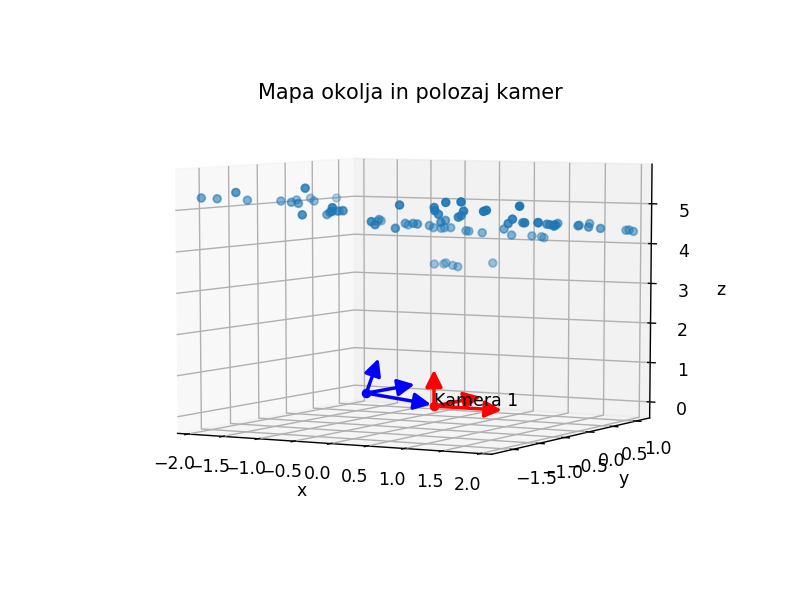

<IPython.core.display.Javascript object>


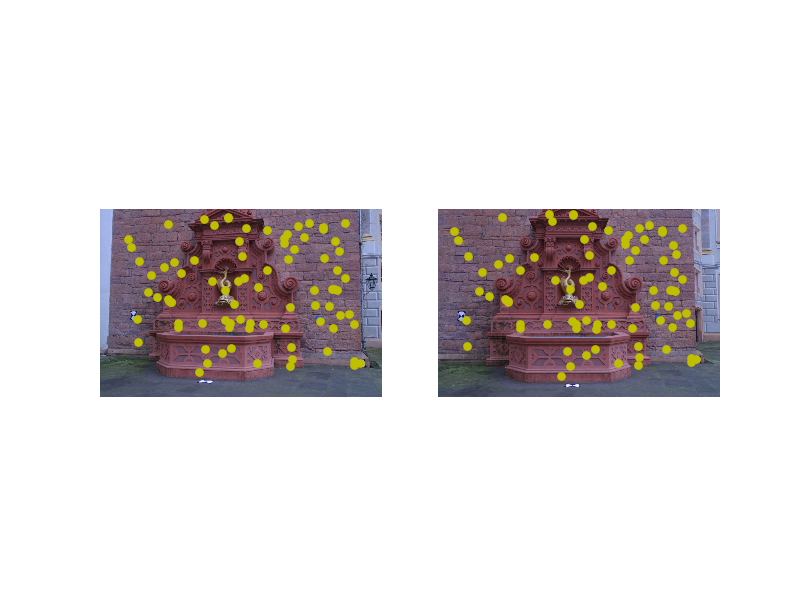

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import PIL.Image as im

img_1 = np.array(im.open('data/0001.jpg'))
img_2 = np.array(im.open('data/0002.jpg'))

K = np.array(
    (
        (1379.74, 0, 760.35),
        (0, 1382.08, 503.41),
        (0, 0, 1)
    )
)

p1 = np.genfromtxt('data/matches0001.txt')
p2 = np.genfromtxt('data/matches0002.txt')

p1 = np.vstack((p1, np.ones((1, p1.shape[-1]))))
p2 = np.vstack((p2, np.ones((1, p2.shape[-1]))))

# oceni esencialno matriko z algoritmom 8-tock
E = estimateEssentialMatrix(p1, p2, K, K)

# izloci relativen polozaj kamere (R, T) iz esencialne matrike
Rots, u3 = decomposeEssentialMatrix(E)

# najdi resitev med 4-imi moznimi
R_C2_W, T_C2_W = disambiguateRelativePose(Rots, u3, p1, p2, K, K)

# izvedi triangulacijo oblaka tock s koncno preslikavo (R, T)
M1 = np.dot(K, np.eye(3, 4))
M2 = np.dot(K, np.hstack((R_C2_W, T_C2_W)))
P = linearTriangulation(p1, p2, M1, M2)

# vizualiziraj 3d sceno
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

def plotCoordinateFrame(ax, rotation, origin, color):
    for i in range(3):
        lines = [[float(origin[j]), float(origin[j] + rotation[j,i])] for j in range(3)]
        a = Arrow3D(lines[0], lines[1], lines[2], mutation_scale=20,
                    lw=2, arrowstyle="-|>", color=color)
        ax.add_artist(a)
        

%matplotlib notebook
fig = plt.figure()
ax = fig.gca(projection='3d')

# narisi tocke okolja
ax.scatter(P[0, :], P[1, :], P[2, :])

# narisi polozaj kamer
plotCoordinateFrame(ax, np.eye(3), np.zeros((3,1)), 'r')
center_cam2_W = -np.dot(R_C2_W.T, T_C2_W)
plotCoordinateFrame(ax, R_C2_W.T, center_cam2_W, 'b')
ax.scatter(0, 0, 0, c='r')    
ax.scatter(center_cam2_W[0], center_cam2_W[1], center_cam2_W[2], c='b')

ax.text(0, 0, 0, 'Kamera 1')
# ax.text(center_cam2_W[0], center_cam2_W[1], center_cam2_W[2], 'Kamera 2')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Mapa okolja in polozaj kamer')    

plt.axis('equal')
plt.show()

plt.figure()
plt.subplot(1,2,1)
plt.imshow(img_1)
plt.axis('off')
plt.plot(p1[0, :], p1[1, :], marker='.', lw=0, ms=8, mfc=None, c='y',mew=1, mec='y')
plt.subplot(1,2,2)
plt.imshow(img_2)
plt.axis('off')
plt.plot(p2[0, :], p2[1, :], marker='.', lw=0, ms=8, mfc=None, c='y', mew=1, mec='y')

# Dodatne naloge in vprašanja
Dodatne naloge naj služijo za poglobitev spretnosti programiranja, boljšemu razumevanju snovi in vsebine vaje in spoznavanju dodatnih načinov za obdelavo in analizo slik. Opravljanje dodatnih nalog je neobvezno, vendar pa priporočljivo, saj je na nek način to priprava na pisni in ustni izpit.

Preizkusite delovanje algoritmov na slikah, ki jih zajamete z lastnim fotoaparatom. Pred tem kalibrirajte fotoaparat tako, da večkrat slikate šahovnico in nato določite intrinzične parametre kamere s funkcijami v knjižnici `OpenCV` (dodatne naloge pri Vaji 6). Nastavitev fotoaparata nato ne spreminjajte (enak zoom in fokus -- izklopite avtofokus). Zajemite več slik prostora in rekonstruirajte 3D okolje kot oblak točk. Ali dobite smiselno rešitev za lokalizacijo (položaj kamere med zajemom) in okolja?

Rešitev, ki ste jo dobili lahko še izboljšate s skupinskim popravkom (t.i. *bundle
adjustment*), pri čemer se lahko zgledujete po naslednji rešitvi: http://scipy-cookbook.readthedocs.io/items/bundle_adjustment.html